# This code implements segmentation of of cysts from OCT images using the variants of U-net, wUnet and Unet++

## This code implements multi-class classification
## This model is adapted from the original codebase in https://github.com/HZCTony/U-net-with-multiple-classification

In [1]:
 import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/home/sohini/U-net_multi-class/Paper-work/Lung-Data/covid-19med/')
PATH='./'


# First, we create a directry of randomly sampled training and test images

In [2]:
if not os.path.exists(PATH+'train'):
    os.makedirs(PATH+'train')
if not os.path.exists(PATH+'train/Images/'):
    os.makedirs(PATH+'train/Images/')
if not os.path.exists(PATH+'train/GT/'):
    os.makedirs(PATH+'train/GT/')
    
if not os.path.exists(PATH+'test'):
    os.makedirs(PATH+'test')    
if not os.path.exists(PATH+'test/Images/'):
    os.makedirs(PATH+'test/Images/')
if not os.path.exists(PATH+'test/GT/'):
    os.makedirs(PATH+'test/GT/')
    
if not os.path.exists(PATH+'pred'):
    os.makedirs(PATH+'pred')  



# Randomly split the data in "Images" into 50/50

In [3]:
# files=(os.listdir('./Images/'))
# print(len(files))

In [4]:
# import numpy as np 
# nums=np.random.permutation(len(files))
# n=int(len(files)/2)
# print(n)

In [5]:
# from shutil import copyfile

# #This is train data
# for i in range(n):
#     copyfile('./Images/'+files[nums[i]],PATH+'train/Images/'+files[nums[i]])
#     copyfile('./GT/'+files[nums[i]],PATH+'train/GT/'+files[nums[i]])
    

In [6]:
# # This is test data
# for i in range(n+1,len(files)):
#     copyfile('./Images/'+files[nums[i]],PATH+'test/Images/'+files[nums[i]])
#     copyfile('./GT/'+files[nums[i]],PATH+'test/GT/'+files[nums[i]])

# Train and Test data are now generated. Now we need to train and test

# A. Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [7]:
#Step 1: Load libraries for the U-net Model

import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [8]:
#Step 2: Import the U-net model
from model_new import *
img_size=(256,256)

In [9]:
n_class=2


In [10]:
#mod = wU_Net(img_size[0],img_size[1],1)
mod = Nest_Net(img_size[0],img_size[1],1,1,deep_supervision=False)

In [11]:
mod.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def adjustData(img,mask,flag_multi_class,n_class):
    
    if(flag_multi_class):
        img /= 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (n_class,))
        for i in range(n_class):
            
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img)>1):
        img = img / 255
        mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
            #print(np.shape(mask),np.shape(img))
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        #'./',
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,n_class)
        yield (img,mask)


def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = as_gray)
        print(files[i])
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        #print(np.max(img))
        yield img

In [20]:
#Step 4: Define function to save the test images
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i] = color_dict[i]
      
    return img_out


def saveResult(img_path,save_path,npyfile,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.5]=1
        img[img<=0.5]=0
        io.imsave(os.path.join(save_path, files[i]),img)
        
        
        
def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.2]=1
        img[img<=0.2]=0
        
        I = io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,target_size)
        #dst = cv2.addWeighted(img, 0.5, I, 0.5, 0.0)
        img=np.true_divide((I+img),2)
        io.imsave(os.path.join(save_path, files[i]),img)  

In [21]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    
    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""
   
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        if(np.sum(img)>0):
            img=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        if(np.sum(gth)>0):
            gth=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
            gth=(gth>0.1).astype(int)
        p,r,I,a,f=get_validation_metrics(gth,img)
        if (np.isnan(p)):
          p=1
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "Jac=",IoU/(i+1), "acc=",acc/(i+1), "Dice=",f1_score/(i+1))   

# All definitions are now done! Lets start using the functions now...
# B. Call to image data generator, model initialization, followed by model fitting.

In [22]:
print(os.getcwd())

/home/sohini/U-net_multi-class/Paper-work/Lung-Data/covid-19med


In [27]:
#Step 1: Call to image data generator in keras

#os.chdir('/content/drive/MyDrive/U-net Multi-class/Data_Stacks/')
data_gen_args = dict(rotation_range=0.2,
                     rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.1,
                    zoom_range=[0.8,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
PATH='./train/'

In [28]:
data_gen = trainGenerator(1,PATH,'Images','GT',data_gen_args, save_to_dir = None)

Epoch 0
Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
1.0


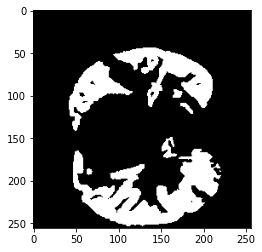

Epoch 1
1.0


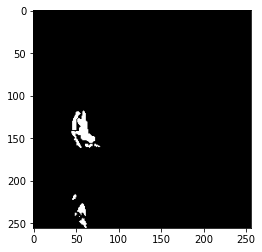

Epoch 2
1.0


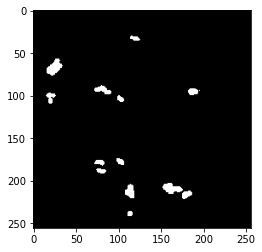

Epoch 3
1.0


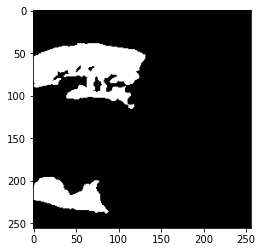

Epoch 4
1.0


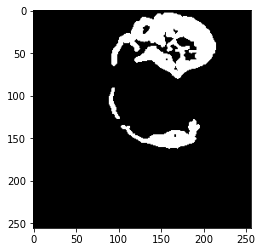

In [29]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in data_gen:
        print(np.max(y_batch))
        plt.imshow(np.squeeze(y_batch), cmap=plt.get_cmap('gray'))
        

        plt.show()
        
        break

In [19]:
#Step 2: Initialize the model. Train from scratch!
# Initialize model like you usually do.
#tf.keras.backend.clear_session()
#mod.compile(optimizer = Adam(learning_rate=0.0001), loss = bce_dice_loss, metrics = dice_coef)
#mod.compile(optimizer = Adam(learning_rate=0.0001), loss = "binary_crossentropy", metrics = "acc")
mod.compile(optimizer = Adam(learning_rate=0.00001), loss = dice_coef_loss, metrics = dice_coef)

In [20]:
# Notice WandbCallback is used as a regular callback
# We again use config
hist = mod.fit(data_gen,steps_per_epoch=10,epochs=20,verbose=1)
          #        mod.fit(x_train, y_train,
          # epochs=50, 
          # batch_size=5, verbose=1)

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Epoch 1/20
10/10 [==============================] - 32s 3s/step - loss: -0.8324 - dice_coef: 0.8324
Epoch 2/20
10/10 [==============================] - 29s 3s/step - loss: -0.8829 - dice_coef: 0.8831
Epoch 3/20
10/10 [==============================] - 30s 3s/step - loss: -0.9218 - dice_coef: 0.9218
Epoch 4/20
10/10 [==============================] - 29s 3s/step - loss: -0.9520 - dice_coef: 0.9518
Epoch 5/20
10/10 [==============================] - 30s 3s/step - loss: -0.9721 - dice_coef: 0.9721
Epoch 6/20
10/10 [==============================] - 29s 3s/step - loss: -0.9894 - dice_coef: 0.9893
Epoch 7/20
10/10 [==============================] - 29s 3s/step - loss: -0.9963 - dice_coef: 0.9963
Epoch 8/20
10/10 [==============================] - 30s 3s/step - loss: -0.9983 - dice_coef: 0.9983
Epoch 9/20
10/10 [==============================] - 29s 3s/step - loss: -0.9989 - dice_coef: 0.9989
Epoch 10/20
10/10 [=

In [21]:
plt.plot(hist.history['output_1_loss'])
plt.plot(hist.history['output_2_loss'])
plt.plot(hist.history['output_3_loss'])
plt.plot(hist.history['output_4_loss'])

KeyError: 'output_1_loss'

# Generate results!

In [ ]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./test/Images/'))
#Call test generator
test_gen= testGenerator('./test/Images/')


In [ ]:
#Return model outcome for each test image
results = mod.predict_generator(test_gen,n_i,verbose=1)

In [ ]:
#Lets save the STARE predictions
SaveResultwImage('./test/Image/','./pred/',results[3])

In [ ]:
np.shape(results)

In [ ]:
#Lets visualize the STARE predictions
plt.imshow(results[3][5][:,:,0])

In [ ]:
# Results of nested Level 1
evalResult('./cirrus_2/test/GT/',results[0])

In [ ]:
evalResult('./cirrus_2/test/GT/',results[1])

In [ ]:
evalResult('./cirrus_2/test/GT/',results[2])

In [ ]:
evalResult('./cirrus_2/test/GT/',results[3])